In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = ''

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        #{'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['t1'],
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_t1_1_0_bas_data_nor_e_e_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 1)
(878801, 3)
validation
(151459, 1)
(151459, 3)
test
(112754, 1)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1)]               0         


 dense (Dense)               (None, 1024)              2048      


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 691459 (2.64 MB)


Trainable params: 691459 (2.64 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 40s - loss: 1.0742 - STD: 0.0772 - MAE: 0.4333

2/9 [=====>........................] - ETA: 0s - loss: 1.1267 - STD: 0.0831 - MAE: 0.4446 

3/9 [=========>....................] - ETA: 0s - loss: 1.1101 - STD: 0.0768 - MAE: 0.4416

4/9 [============>.................] - ETA: 5s - loss: 1.1073 - STD: 0.0914 - MAE: 0.4372

5/9 [===============>..............] - ETA: 3s - loss: 1.1115 - STD: 0.1035 - MAE: 0.4344

6/9 [===================>..........] - ETA: 1s - loss: 1.1135 - STD: 0.1108 - MAE: 0.4327

7/9 [======================>.......] - ETA: 1s - loss: 1.1114 - STD: 0.1133 - MAE: 0.4318

8/9 [=========================>....] - ETA: 0s - loss: 1.1072 - STD: 0.1116 - MAE: 0.4316

9/9 [==============================] - ETA: 0s - loss: 1.1033 - STD: 0.1065 - MAE: 0.4319

9/9 [==============================] - 10s 615ms/step - loss: 1.1033 - STD: 0.1065 - MAE: 0.4319 - val_loss: 1.0830 - val_STD: 0.0403 - val_MAE: 0.4393


Epoch 2/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0817 - STD: 0.0392 - MAE: 0.4391

2/9 [=====>........................] - ETA: 0s - loss: 1.0869 - STD: 0.0350 - MAE: 0.4405

3/9 [=========>....................] - ETA: 0s - loss: 1.0887 - STD: 0.0332 - MAE: 0.4410

4/9 [============>.................] - ETA: 0s - loss: 1.0876 - STD: 0.0334 - MAE: 0.4408

5/9 [===============>..............] - ETA: 0s - loss: 1.0853 - STD: 0.0365 - MAE: 0.4400

7/9 [======================>.......] - ETA: 0s - loss: 1.0818 - STD: 0.0478 - MAE: 0.4380

8/9 [=========================>....] - ETA: 0s - loss: 1.0809 - STD: 0.0540 - MAE: 0.4369

9/9 [==============================] - ETA: 0s - loss: 1.0807 - STD: 0.0596 - MAE: 0.4360

9/9 [==============================] - 1s 82ms/step - loss: 1.0807 - STD: 0.0596 - MAE: 0.4360 - val_loss: 1.0783 - val_STD: 0.1074 - val_MAE: 0.4280


Epoch 3/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0774 - STD: 0.1064 - MAE: 0.4279

2/9 [=====>........................] - ETA: 0s - loss: 1.0764 - STD: 0.1054 - MAE: 0.4280

3/9 [=========>....................] - ETA: 0s - loss: 1.0756 - STD: 0.1030 - MAE: 0.4283

4/9 [============>.................] - ETA: 0s - loss: 1.0741 - STD: 0.0994 - MAE: 0.4288

5/9 [===============>..............] - ETA: 0s - loss: 1.0729 - STD: 0.0949 - MAE: 0.4294

6/9 [===================>..........] - ETA: 0s - loss: 1.0720 - STD: 0.0899 - MAE: 0.4300

7/9 [======================>.......] - ETA: 0s - loss: 1.0716 - STD: 0.0850 - MAE: 0.4307

8/9 [=========================>....] - ETA: 0s - loss: 1.0712 - STD: 0.0807 - MAE: 0.4312

9/9 [==============================] - ETA: 0s - loss: 1.0709 - STD: 0.0775 - MAE: 0.4316

9/9 [==============================] - 1s 80ms/step - loss: 1.0709 - STD: 0.0775 - MAE: 0.4316 - val_loss: 1.0689 - val_STD: 0.0636 - val_MAE: 0.4337


Epoch 4/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0657 - STD: 0.0557 - MAE: 0.4339

2/9 [=====>........................] - ETA: 0s - loss: 1.0646 - STD: 0.0586 - MAE: 0.4333

3/9 [=========>....................] - ETA: 0s - loss: 1.0635 - STD: 0.0616 - MAE: 0.4327

4/9 [============>.................] - ETA: 0s - loss: 1.0628 - STD: 0.0652 - MAE: 0.4319

5/9 [===============>..............] - ETA: 0s - loss: 1.0620 - STD: 0.0690 - MAE: 0.4312

6/9 [===================>..........] - ETA: 0s - loss: 1.0609 - STD: 0.0725 - MAE: 0.4304

7/9 [======================>.......] - ETA: 0s - loss: 1.0603 - STD: 0.0756 - MAE: 0.4297

8/9 [=========================>....] - ETA: 0s - loss: 1.0594 - STD: 0.0779 - MAE: 0.4291

9/9 [==============================] - ETA: 0s - loss: 1.0587 - STD: 0.0795 - MAE: 0.4287

9/9 [==============================] - 1s 78ms/step - loss: 1.0587 - STD: 0.0795 - MAE: 0.4287 - val_loss: 1.0586 - val_STD: 0.1080 - val_MAE: 0.4236


Epoch 5/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0492 - STD: 0.0913 - MAE: 0.4245

2/9 [=====>........................] - ETA: 0s - loss: 1.0476 - STD: 0.0884 - MAE: 0.4246

3/9 [=========>....................] - ETA: 0s - loss: 1.0467 - STD: 0.0878 - MAE: 0.4245

4/9 [============>.................] - ETA: 0s - loss: 1.0461 - STD: 0.0856 - MAE: 0.4248

5/9 [===============>..............] - ETA: 0s - loss: 1.0453 - STD: 0.0855 - MAE: 0.4247

6/9 [===================>..........] - ETA: 0s - loss: 1.0446 - STD: 0.0855 - MAE: 0.4245

7/9 [======================>.......] - ETA: 0s - loss: 1.0438 - STD: 0.0864 - MAE: 0.4241

8/9 [=========================>....] - ETA: 0s - loss: 1.0428 - STD: 0.0879 - MAE: 0.4236

9/9 [==============================] - ETA: 0s - loss: 1.0416 - STD: 0.0899 - MAE: 0.4230

9/9 [==============================] - 1s 76ms/step - loss: 1.0416 - STD: 0.0899 - MAE: 0.4230 - val_loss: 1.0609 - val_STD: 0.1449 - val_MAE: 0.4150


Epoch 6/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0343 - STD: 0.1125 - MAE: 0.4168

2/9 [=====>........................] - ETA: 0s - loss: 1.0323 - STD: 0.1151 - MAE: 0.4158

3/9 [=========>....................] - ETA: 0s - loss: 1.0326 - STD: 0.1186 - MAE: 0.4150

4/9 [============>.................] - ETA: 0s - loss: 1.0343 - STD: 0.1192 - MAE: 0.4153

5/9 [===============>..............] - ETA: 0s - loss: 1.0355 - STD: 0.1243 - MAE: 0.4143

6/9 [===================>..........] - ETA: 0s - loss: 1.0343 - STD: 0.1243 - MAE: 0.4140

7/9 [======================>.......] - ETA: 0s - loss: 1.0352 - STD: 0.1230 - MAE: 0.4146

8/9 [=========================>....] - ETA: 0s - loss: 1.0343 - STD: 0.1217 - MAE: 0.4147

9/9 [==============================] - ETA: 0s - loss: 1.0343 - STD: 0.1222 - MAE: 0.4146

9/9 [==============================] - 1s 76ms/step - loss: 1.0343 - STD: 0.1222 - MAE: 0.4146 - val_loss: 1.0673 - val_STD: 0.1458 - val_MAE: 0.4160


Epoch 7/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0304 - STD: 0.1167 - MAE: 0.4150

2/9 [=====>........................] - ETA: 0s - loss: 1.0308 - STD: 0.1122 - MAE: 0.4163

3/9 [=========>....................] - ETA: 0s - loss: 1.0310 - STD: 0.1112 - MAE: 0.4166

4/9 [============>.................] - ETA: 0s - loss: 1.0303 - STD: 0.1128 - MAE: 0.4161

6/9 [===================>..........] - ETA: 0s - loss: 1.0293 - STD: 0.1164 - MAE: 0.4149

7/9 [======================>.......] - ETA: 0s - loss: 1.0289 - STD: 0.1166 - MAE: 0.4149

8/9 [=========================>....] - ETA: 0s - loss: 1.0288 - STD: 0.1167 - MAE: 0.4148

9/9 [==============================] - ETA: 0s - loss: 1.0282 - STD: 0.1174 - MAE: 0.4145

9/9 [==============================] - 1s 74ms/step - loss: 1.0282 - STD: 0.1174 - MAE: 0.4145 - val_loss: 1.0638 - val_STD: 0.1496 - val_MAE: 0.4145


Epoch 8/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0287 - STD: 0.1263 - MAE: 0.4124

2/9 [=====>........................] - ETA: 0s - loss: 1.0269 - STD: 0.1236 - MAE: 0.4127

3/9 [=========>....................] - ETA: 0s - loss: 1.0266 - STD: 0.1214 - MAE: 0.4132

4/9 [============>.................] - ETA: 0s - loss: 1.0264 - STD: 0.1203 - MAE: 0.4135

5/9 [===============>..............] - ETA: 0s - loss: 1.0261 - STD: 0.1205 - MAE: 0.4134

6/9 [===================>..........] - ETA: 0s - loss: 1.0257 - STD: 0.1216 - MAE: 0.4130

7/9 [======================>.......] - ETA: 0s - loss: 1.0250 - STD: 0.1221 - MAE: 0.4127

8/9 [=========================>....] - ETA: 0s - loss: 1.0253 - STD: 0.1225 - MAE: 0.4127

9/9 [==============================] - ETA: 0s - loss: 1.0250 - STD: 0.1232 - MAE: 0.4125

9/9 [==============================] - 1s 76ms/step - loss: 1.0250 - STD: 0.1232 - MAE: 0.4125 - val_loss: 1.0639 - val_STD: 0.1578 - val_MAE: 0.4121


Epoch 9/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0250 - STD: 0.1341 - MAE: 0.4097

2/9 [=====>........................] - ETA: 0s - loss: 1.0242 - STD: 0.1342 - MAE: 0.4095

3/9 [=========>....................] - ETA: 0s - loss: 1.0236 - STD: 0.1332 - MAE: 0.4097

4/9 [============>.................] - ETA: 0s - loss: 1.0234 - STD: 0.1321 - MAE: 0.4099

5/9 [===============>..............] - ETA: 0s - loss: 1.0237 - STD: 0.1316 - MAE: 0.4101

6/9 [===================>..........] - ETA: 0s - loss: 1.0235 - STD: 0.1312 - MAE: 0.4102

7/9 [======================>.......] - ETA: 0s - loss: 1.0234 - STD: 0.1306 - MAE: 0.4103

8/9 [=========================>....] - ETA: 0s - loss: 1.0229 - STD: 0.1299 - MAE: 0.4104

9/9 [==============================] - ETA: 0s - loss: 1.0232 - STD: 0.1293 - MAE: 0.4106

9/9 [==============================] - 1s 79ms/step - loss: 1.0232 - STD: 0.1293 - MAE: 0.4106 - val_loss: 1.0555 - val_STD: 0.1445 - val_MAE: 0.4141


Epoch 10/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0248 - STD: 0.1269 - MAE: 0.4116

2/9 [=====>........................] - ETA: 0s - loss: 1.0233 - STD: 0.1269 - MAE: 0.4113

3/9 [=========>....................] - ETA: 0s - loss: 1.0230 - STD: 0.1270 - MAE: 0.4112

4/9 [============>.................] - ETA: 0s - loss: 1.0228 - STD: 0.1270 - MAE: 0.4112

5/9 [===============>..............] - ETA: 0s - loss: 1.0228 - STD: 0.1271 - MAE: 0.4111

6/9 [===================>..........] - ETA: 0s - loss: 1.0226 - STD: 0.1275 - MAE: 0.4110

7/9 [======================>.......] - ETA: 0s - loss: 1.0223 - STD: 0.1277 - MAE: 0.4109

8/9 [=========================>....] - ETA: 0s - loss: 1.0222 - STD: 0.1278 - MAE: 0.4108

9/9 [==============================] - ETA: 0s - loss: 1.0221 - STD: 0.1279 - MAE: 0.4108

9/9 [==============================] - 1s 78ms/step - loss: 1.0221 - STD: 0.1279 - MAE: 0.4108 - val_loss: 1.0540 - val_STD: 0.1466 - val_MAE: 0.4132


Epoch 11/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0243 - STD: 0.1303 - MAE: 0.4107

2/9 [=====>........................] - ETA: 0s - loss: 1.0224 - STD: 0.1304 - MAE: 0.4102

3/9 [=========>....................] - ETA: 0s - loss: 1.0215 - STD: 0.1302 - MAE: 0.4100

4/9 [============>.................] - ETA: 0s - loss: 1.0220 - STD: 0.1302 - MAE: 0.4102

5/9 [===============>..............] - ETA: 0s - loss: 1.0214 - STD: 0.1304 - MAE: 0.4100

6/9 [===================>..........] - ETA: 0s - loss: 1.0217 - STD: 0.1305 - MAE: 0.4100

7/9 [======================>.......] - ETA: 0s - loss: 1.0217 - STD: 0.1305 - MAE: 0.4101

8/9 [=========================>....] - ETA: 0s - loss: 1.0217 - STD: 0.1304 - MAE: 0.4101

9/9 [==============================] - ETA: 0s - loss: 1.0215 - STD: 0.1304 - MAE: 0.4101

9/9 [==============================] - 1s 79ms/step - loss: 1.0215 - STD: 0.1304 - MAE: 0.4101 - val_loss: 1.0516 - val_STD: 0.1443 - val_MAE: 0.4134


Epoch 12/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0215 - STD: 0.1301 - MAE: 0.4102

2/9 [=====>........................] - ETA: 0s - loss: 1.0212 - STD: 0.1299 - MAE: 0.4101

3/9 [=========>....................] - ETA: 0s - loss: 1.0214 - STD: 0.1297 - MAE: 0.4102

4/9 [============>.................] - ETA: 0s - loss: 1.0218 - STD: 0.1298 - MAE: 0.4103

5/9 [===============>..............] - ETA: 0s - loss: 1.0214 - STD: 0.1297 - MAE: 0.4102

6/9 [===================>..........] - ETA: 0s - loss: 1.0215 - STD: 0.1296 - MAE: 0.4103

7/9 [======================>.......] - ETA: 0s - loss: 1.0212 - STD: 0.1297 - MAE: 0.4102

8/9 [=========================>....] - ETA: 0s - loss: 1.0210 - STD: 0.1297 - MAE: 0.4102

9/9 [==============================] - ETA: 0s - loss: 1.0211 - STD: 0.1298 - MAE: 0.4102

9/9 [==============================] - 1s 79ms/step - loss: 1.0211 - STD: 0.1298 - MAE: 0.4102 - val_loss: 1.0503 - val_STD: 0.1437 - val_MAE: 0.4133


Epoch 13/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0212 - STD: 0.1304 - MAE: 0.4100

2/9 [=====>........................] - ETA: 0s - loss: 1.0213 - STD: 0.1303 - MAE: 0.4101

3/9 [=========>....................] - ETA: 0s - loss: 1.0211 - STD: 0.1304 - MAE: 0.4100

4/9 [============>.................] - ETA: 0s - loss: 1.0216 - STD: 0.1306 - MAE: 0.4101

5/9 [===============>..............] - ETA: 0s - loss: 1.0216 - STD: 0.1307 - MAE: 0.4101

6/9 [===================>..........] - ETA: 0s - loss: 1.0217 - STD: 0.1307 - MAE: 0.4101

7/9 [======================>.......] - ETA: 0s - loss: 1.0214 - STD: 0.1307 - MAE: 0.4100

8/9 [=========================>....] - ETA: 0s - loss: 1.0210 - STD: 0.1306 - MAE: 0.4099

9/9 [==============================] - ETA: 0s - loss: 1.0209 - STD: 0.1306 - MAE: 0.4099

9/9 [==============================] - 1s 73ms/step - loss: 1.0209 - STD: 0.1306 - MAE: 0.4099 - val_loss: 1.0512 - val_STD: 0.1454 - val_MAE: 0.4130


Epoch 14/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0196 - STD: 0.1314 - MAE: 0.4094

2/9 [=====>........................] - ETA: 0s - loss: 1.0205 - STD: 0.1319 - MAE: 0.4095

3/9 [=========>....................] - ETA: 0s - loss: 1.0210 - STD: 0.1319 - MAE: 0.4096

4/9 [============>.................] - ETA: 0s - loss: 1.0207 - STD: 0.1318 - MAE: 0.4096

6/9 [===================>..........] - ETA: 0s - loss: 1.0206 - STD: 0.1315 - MAE: 0.4096

7/9 [======================>.......] - ETA: 0s - loss: 1.0207 - STD: 0.1312 - MAE: 0.4097

8/9 [=========================>....] - ETA: 0s - loss: 1.0208 - STD: 0.1309 - MAE: 0.4098

9/9 [==============================] - ETA: 0s - loss: 1.0206 - STD: 0.1308 - MAE: 0.4098

9/9 [==============================] - 1s 70ms/step - loss: 1.0206 - STD: 0.1308 - MAE: 0.4098 - val_loss: 1.0529 - val_STD: 0.1459 - val_MAE: 0.4133


Epoch 15/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0205 - STD: 0.1310 - MAE: 0.4097

2/9 [=====>........................] - ETA: 0s - loss: 1.0205 - STD: 0.1309 - MAE: 0.4098

3/9 [=========>....................] - ETA: 0s - loss: 1.0215 - STD: 0.1310 - MAE: 0.4100

4/9 [============>.................] - ETA: 0s - loss: 1.0217 - STD: 0.1318 - MAE: 0.4098

5/9 [===============>..............] - ETA: 0s - loss: 1.0211 - STD: 0.1320 - MAE: 0.4096

6/9 [===================>..........] - ETA: 0s - loss: 1.0210 - STD: 0.1319 - MAE: 0.4096

7/9 [======================>.......] - ETA: 0s - loss: 1.0207 - STD: 0.1316 - MAE: 0.4096

8/9 [=========================>....] - ETA: 0s - loss: 1.0207 - STD: 0.1315 - MAE: 0.4097

9/9 [==============================] - ETA: 0s - loss: 1.0205 - STD: 0.1313 - MAE: 0.4097

9/9 [==============================] - 1s 81ms/step - loss: 1.0205 - STD: 0.1313 - MAE: 0.4097 - val_loss: 1.0474 - val_STD: 0.1403 - val_MAE: 0.4136


Epoch 16/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0217 - STD: 0.1295 - MAE: 0.4104

2/9 [=====>........................] - ETA: 0s - loss: 1.0208 - STD: 0.1301 - MAE: 0.4101

3/9 [=========>....................] - ETA: 0s - loss: 1.0201 - STD: 0.1311 - MAE: 0.4096

4/9 [============>.................] - ETA: 0s - loss: 1.0203 - STD: 0.1315 - MAE: 0.4096

6/9 [===================>..........] - ETA: 0s - loss: 1.0206 - STD: 0.1320 - MAE: 0.4095

7/9 [======================>.......] - ETA: 0s - loss: 1.0204 - STD: 0.1321 - MAE: 0.4095

8/9 [=========================>....] - ETA: 0s - loss: 1.0203 - STD: 0.1319 - MAE: 0.4095

9/9 [==============================] - ETA: 0s - loss: 1.0203 - STD: 0.1317 - MAE: 0.4095

9/9 [==============================] - 1s 74ms/step - loss: 1.0203 - STD: 0.1317 - MAE: 0.4095 - val_loss: 1.0510 - val_STD: 0.1444 - val_MAE: 0.4133


Epoch 17/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0205 - STD: 0.1309 - MAE: 0.4098

2/9 [=====>........................] - ETA: 0s - loss: 1.0198 - STD: 0.1307 - MAE: 0.4097

3/9 [=========>....................] - ETA: 0s - loss: 1.0206 - STD: 0.1305 - MAE: 0.4099

4/9 [============>.................] - ETA: 0s - loss: 1.0202 - STD: 0.1307 - MAE: 0.4098

5/9 [===============>..............] - ETA: 0s - loss: 1.0200 - STD: 0.1314 - MAE: 0.4096

6/9 [===================>..........] - ETA: 0s - loss: 1.0205 - STD: 0.1315 - MAE: 0.4096

7/9 [======================>.......] - ETA: 0s - loss: 1.0206 - STD: 0.1314 - MAE: 0.4097

8/9 [=========================>....] - ETA: 0s - loss: 1.0202 - STD: 0.1313 - MAE: 0.4096

9/9 [==============================] - ETA: 0s - loss: 1.0202 - STD: 0.1317 - MAE: 0.4095

9/9 [==============================] - 1s 75ms/step - loss: 1.0202 - STD: 0.1317 - MAE: 0.4095 - val_loss: 1.0491 - val_STD: 0.1431 - val_MAE: 0.4133


Epoch 18/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0217 - STD: 0.1303 - MAE: 0.4102

2/9 [=====>........................] - ETA: 0s - loss: 1.0217 - STD: 0.1300 - MAE: 0.4103

3/9 [=========>....................] - ETA: 0s - loss: 1.0214 - STD: 0.1305 - MAE: 0.4101

4/9 [============>.................] - ETA: 0s - loss: 1.0210 - STD: 0.1308 - MAE: 0.4099

5/9 [===============>..............] - ETA: 0s - loss: 1.0206 - STD: 0.1309 - MAE: 0.4098

6/9 [===================>..........] - ETA: 0s - loss: 1.0204 - STD: 0.1309 - MAE: 0.4098

7/9 [======================>.......] - ETA: 0s - loss: 1.0202 - STD: 0.1311 - MAE: 0.4097

8/9 [=========================>....] - ETA: 0s - loss: 1.0200 - STD: 0.1314 - MAE: 0.4096

9/9 [==============================] - ETA: 0s - loss: 1.0201 - STD: 0.1314 - MAE: 0.4096

9/9 [==============================] - 1s 75ms/step - loss: 1.0201 - STD: 0.1314 - MAE: 0.4096 - val_loss: 1.0476 - val_STD: 0.1433 - val_MAE: 0.4129


Epoch 19/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0194 - STD: 0.1326 - MAE: 0.4091

2/9 [=====>........................] - ETA: 0s - loss: 1.0207 - STD: 0.1331 - MAE: 0.4093

3/9 [=========>....................] - ETA: 0s - loss: 1.0199 - STD: 0.1333 - MAE: 0.4091

4/9 [============>.................] - ETA: 0s - loss: 1.0199 - STD: 0.1329 - MAE: 0.4092

5/9 [===============>..............] - ETA: 0s - loss: 1.0202 - STD: 0.1326 - MAE: 0.4093

6/9 [===================>..........] - ETA: 0s - loss: 1.0203 - STD: 0.1321 - MAE: 0.4094

7/9 [======================>.......] - ETA: 0s - loss: 1.0201 - STD: 0.1320 - MAE: 0.4094

8/9 [=========================>....] - ETA: 0s - loss: 1.0200 - STD: 0.1318 - MAE: 0.4095

9/9 [==============================] - ETA: 0s - loss: 1.0199 - STD: 0.1318 - MAE: 0.4095

9/9 [==============================] - 1s 72ms/step - loss: 1.0199 - STD: 0.1318 - MAE: 0.4095 - val_loss: 1.0522 - val_STD: 0.1473 - val_MAE: 0.4129


Epoch 20/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0206 - STD: 0.1337 - MAE: 0.4090

2/9 [=====>........................] - ETA: 0s - loss: 1.0202 - STD: 0.1334 - MAE: 0.4090

3/9 [=========>....................] - ETA: 0s - loss: 1.0199 - STD: 0.1334 - MAE: 0.4090

4/9 [============>.................] - ETA: 0s - loss: 1.0201 - STD: 0.1332 - MAE: 0.4091

5/9 [===============>..............] - ETA: 0s - loss: 1.0200 - STD: 0.1331 - MAE: 0.4091

6/9 [===================>..........] - ETA: 0s - loss: 1.0198 - STD: 0.1327 - MAE: 0.4092

7/9 [======================>.......] - ETA: 0s - loss: 1.0198 - STD: 0.1325 - MAE: 0.4092

8/9 [=========================>....] - ETA: 0s - loss: 1.0198 - STD: 0.1323 - MAE: 0.4093

9/9 [==============================] - ETA: 0s - loss: 1.0198 - STD: 0.1322 - MAE: 0.4093

9/9 [==============================] - 1s 73ms/step - loss: 1.0198 - STD: 0.1322 - MAE: 0.4093 - val_loss: 1.0487 - val_STD: 0.1433 - val_MAE: 0.4132


Epoch 21/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0205 - STD: 0.1319 - MAE: 0.4096

2/9 [=====>........................] - ETA: 0s - loss: 1.0207 - STD: 0.1324 - MAE: 0.4095

3/9 [=========>....................] - ETA: 0s - loss: 1.0205 - STD: 0.1321 - MAE: 0.4095

4/9 [============>.................] - ETA: 0s - loss: 1.0206 - STD: 0.1325 - MAE: 0.4094

5/9 [===============>..............] - ETA: 0s - loss: 1.0203 - STD: 0.1325 - MAE: 0.4093

6/9 [===================>..........] - ETA: 0s - loss: 1.0201 - STD: 0.1326 - MAE: 0.4093

7/9 [======================>.......] - ETA: 0s - loss: 1.0200 - STD: 0.1324 - MAE: 0.4093

8/9 [=========================>....] - ETA: 0s - loss: 1.0199 - STD: 0.1322 - MAE: 0.4093

9/9 [==============================] - ETA: 0s - loss: 1.0197 - STD: 0.1321 - MAE: 0.4093

9/9 [==============================] - 1s 73ms/step - loss: 1.0197 - STD: 0.1321 - MAE: 0.4093 - val_loss: 1.0504 - val_STD: 0.1452 - val_MAE: 0.4131


Epoch 22/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0197 - STD: 0.1327 - MAE: 0.4091

2/9 [=====>........................] - ETA: 0s - loss: 1.0184 - STD: 0.1334 - MAE: 0.4087

3/9 [=========>....................] - ETA: 0s - loss: 1.0186 - STD: 0.1334 - MAE: 0.4087

4/9 [============>.................] - ETA: 0s - loss: 1.0187 - STD: 0.1335 - MAE: 0.4087

5/9 [===============>..............] - ETA: 0s - loss: 1.0189 - STD: 0.1339 - MAE: 0.4086

6/9 [===================>..........] - ETA: 0s - loss: 1.0192 - STD: 0.1338 - MAE: 0.4087

7/9 [======================>.......] - ETA: 0s - loss: 1.0195 - STD: 0.1334 - MAE: 0.4089

9/9 [==============================] - ETA: 0s - loss: 1.0197 - STD: 0.1329 - MAE: 0.4091

9/9 [==============================] - 1s 77ms/step - loss: 1.0197 - STD: 0.1329 - MAE: 0.4091 - val_loss: 1.0454 - val_STD: 0.1371 - val_MAE: 0.4141


Epoch 23/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0201 - STD: 0.1288 - MAE: 0.4102

2/9 [=====>........................] - ETA: 0s - loss: 1.0197 - STD: 0.1297 - MAE: 0.4099

3/9 [=========>....................] - ETA: 0s - loss: 1.0196 - STD: 0.1311 - MAE: 0.4095

4/9 [============>.................] - ETA: 0s - loss: 1.0193 - STD: 0.1317 - MAE: 0.4093

5/9 [===============>..............] - ETA: 0s - loss: 1.0193 - STD: 0.1319 - MAE: 0.4092

6/9 [===================>..........] - ETA: 0s - loss: 1.0195 - STD: 0.1321 - MAE: 0.4092

7/9 [======================>.......] - ETA: 0s - loss: 1.0196 - STD: 0.1324 - MAE: 0.4092

8/9 [=========================>....] - ETA: 0s - loss: 1.0197 - STD: 0.1323 - MAE: 0.4093

9/9 [==============================] - ETA: 0s - loss: 1.0197 - STD: 0.1322 - MAE: 0.4093

9/9 [==============================] - 1s 74ms/step - loss: 1.0197 - STD: 0.1322 - MAE: 0.4093 - val_loss: 1.0502 - val_STD: 0.1436 - val_MAE: 0.4134


Epoch 24/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0193 - STD: 0.1320 - MAE: 0.4092

2/9 [=====>........................] - ETA: 0s - loss: 1.0192 - STD: 0.1322 - MAE: 0.4092

3/9 [=========>....................] - ETA: 0s - loss: 1.0185 - STD: 0.1323 - MAE: 0.4090

4/9 [============>.................] - ETA: 0s - loss: 1.0193 - STD: 0.1327 - MAE: 0.4091

5/9 [===============>..............] - ETA: 0s - loss: 1.0196 - STD: 0.1329 - MAE: 0.4091

6/9 [===================>..........] - ETA: 0s - loss: 1.0194 - STD: 0.1329 - MAE: 0.4090

7/9 [======================>.......] - ETA: 0s - loss: 1.0195 - STD: 0.1326 - MAE: 0.4091

8/9 [=========================>....] - ETA: 0s - loss: 1.0197 - STD: 0.1324 - MAE: 0.4092

9/9 [==============================] - ETA: 0s - loss: 1.0196 - STD: 0.1323 - MAE: 0.4092

9/9 [==============================] - 1s 77ms/step - loss: 1.0196 - STD: 0.1323 - MAE: 0.4092 - val_loss: 1.0487 - val_STD: 0.1421 - val_MAE: 0.4135


Epoch 25/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0187 - STD: 0.1317 - MAE: 0.4092

2/9 [=====>........................] - ETA: 0s - loss: 1.0185 - STD: 0.1328 - MAE: 0.4089

3/9 [=========>....................] - ETA: 0s - loss: 1.0191 - STD: 0.1329 - MAE: 0.4090

4/9 [============>.................] - ETA: 0s - loss: 1.0195 - STD: 0.1333 - MAE: 0.4090

5/9 [===============>..............] - ETA: 0s - loss: 1.0200 - STD: 0.1335 - MAE: 0.4090

6/9 [===================>..........] - ETA: 0s - loss: 1.0198 - STD: 0.1330 - MAE: 0.4091

7/9 [======================>.......] - ETA: 0s - loss: 1.0193 - STD: 0.1329 - MAE: 0.4090

8/9 [=========================>....] - ETA: 0s - loss: 1.0196 - STD: 0.1329 - MAE: 0.4091

9/9 [==============================] - ETA: 0s - loss: 1.0196 - STD: 0.1328 - MAE: 0.4091

9/9 [==============================] - 1s 71ms/step - loss: 1.0196 - STD: 0.1328 - MAE: 0.4091 - val_loss: 1.0459 - val_STD: 0.1391 - val_MAE: 0.4137


Epoch 26/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0203 - STD: 0.1303 - MAE: 0.4099

2/9 [=====>........................] - ETA: 0s - loss: 1.0203 - STD: 0.1313 - MAE: 0.4097

3/9 [=========>....................] - ETA: 0s - loss: 1.0200 - STD: 0.1316 - MAE: 0.4095

4/9 [============>.................] - ETA: 0s - loss: 1.0200 - STD: 0.1314 - MAE: 0.4096

5/9 [===============>..............] - ETA: 0s - loss: 1.0198 - STD: 0.1320 - MAE: 0.4094

6/9 [===================>..........] - ETA: 0s - loss: 1.0195 - STD: 0.1325 - MAE: 0.4092

7/9 [======================>.......] - ETA: 0s - loss: 1.0196 - STD: 0.1326 - MAE: 0.4091

8/9 [=========================>....] - ETA: 0s - loss: 1.0196 - STD: 0.1327 - MAE: 0.4091

9/9 [==============================] - ETA: 0s - loss: 1.0196 - STD: 0.1327 - MAE: 0.4091

9/9 [==============================] - 1s 75ms/step - loss: 1.0196 - STD: 0.1327 - MAE: 0.4091 - val_loss: 1.0483 - val_STD: 0.1414 - val_MAE: 0.4136


Epoch 27/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0179 - STD: 0.1311 - MAE: 0.4091

2/9 [=====>........................] - ETA: 0s - loss: 1.0189 - STD: 0.1313 - MAE: 0.4094

3/9 [=========>....................] - ETA: 0s - loss: 1.0188 - STD: 0.1318 - MAE: 0.4092

4/9 [============>.................] - ETA: 0s - loss: 1.0192 - STD: 0.1320 - MAE: 0.4092

5/9 [===============>..............] - ETA: 0s - loss: 1.0196 - STD: 0.1321 - MAE: 0.4093

6/9 [===================>..........] - ETA: 0s - loss: 1.0194 - STD: 0.1322 - MAE: 0.4092

8/9 [=========================>....] - ETA: 0s - loss: 1.0195 - STD: 0.1324 - MAE: 0.4092

9/9 [==============================] - ETA: 0s - loss: 1.0194 - STD: 0.1323 - MAE: 0.4092

9/9 [==============================] - 1s 74ms/step - loss: 1.0194 - STD: 0.1323 - MAE: 0.4092 - val_loss: 1.0474 - val_STD: 0.1411 - val_MAE: 0.4135


Epoch 28/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0208 - STD: 0.1314 - MAE: 0.4097

2/9 [=====>........................] - ETA: 0s - loss: 1.0186 - STD: 0.1323 - MAE: 0.4090

3/9 [=========>....................] - ETA: 0s - loss: 1.0191 - STD: 0.1329 - MAE: 0.4089

4/9 [============>.................] - ETA: 0s - loss: 1.0193 - STD: 0.1332 - MAE: 0.4089

5/9 [===============>..............] - ETA: 0s - loss: 1.0190 - STD: 0.1336 - MAE: 0.4088

6/9 [===================>..........] - ETA: 0s - loss: 1.0192 - STD: 0.1335 - MAE: 0.4088

7/9 [======================>.......] - ETA: 0s - loss: 1.0191 - STD: 0.1332 - MAE: 0.4089

8/9 [=========================>....] - ETA: 0s - loss: 1.0193 - STD: 0.1330 - MAE: 0.4090

9/9 [==============================] - ETA: 0s - loss: 1.0195 - STD: 0.1327 - MAE: 0.4091

9/9 [==============================] - 1s 73ms/step - loss: 1.0195 - STD: 0.1327 - MAE: 0.4091 - val_loss: 1.0472 - val_STD: 0.1405 - val_MAE: 0.4136


Epoch 29/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0189 - STD: 0.1318 - MAE: 0.4092

2/9 [=====>........................] - ETA: 0s - loss: 1.0194 - STD: 0.1324 - MAE: 0.4091

3/9 [=========>....................] - ETA: 0s - loss: 1.0186 - STD: 0.1329 - MAE: 0.4088

4/9 [============>.................] - ETA: 0s - loss: 1.0188 - STD: 0.1336 - MAE: 0.4087

5/9 [===============>..............] - ETA: 0s - loss: 1.0191 - STD: 0.1336 - MAE: 0.4088

6/9 [===================>..........] - ETA: 0s - loss: 1.0192 - STD: 0.1334 - MAE: 0.4089

7/9 [======================>.......] - ETA: 0s - loss: 1.0193 - STD: 0.1332 - MAE: 0.4090

8/9 [=========================>....] - ETA: 0s - loss: 1.0194 - STD: 0.1330 - MAE: 0.4090

9/9 [==============================] - ETA: 0s - loss: 1.0195 - STD: 0.1326 - MAE: 0.4091

9/9 [==============================] - 1s 76ms/step - loss: 1.0195 - STD: 0.1326 - MAE: 0.4091 - val_loss: 1.0489 - val_STD: 0.1419 - val_MAE: 0.4137


Epoch 30/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0206 - STD: 0.1315 - MAE: 0.4097

2/9 [=====>........................] - ETA: 0s - loss: 1.0204 - STD: 0.1327 - MAE: 0.4093

3/9 [=========>....................] - ETA: 0s - loss: 1.0199 - STD: 0.1328 - MAE: 0.4092

4/9 [============>.................] - ETA: 0s - loss: 1.0195 - STD: 0.1327 - MAE: 0.4091

5/9 [===============>..............] - ETA: 0s - loss: 1.0197 - STD: 0.1330 - MAE: 0.4091

6/9 [===================>..........] - ETA: 0s - loss: 1.0196 - STD: 0.1331 - MAE: 0.4090

7/9 [======================>.......] - ETA: 0s - loss: 1.0194 - STD: 0.1329 - MAE: 0.4090

8/9 [=========================>....] - ETA: 0s - loss: 1.0194 - STD: 0.1327 - MAE: 0.4091

9/9 [==============================] - ETA: 0s - loss: 1.0194 - STD: 0.1326 - MAE: 0.4091

9/9 [==============================] - 1s 73ms/step - loss: 1.0194 - STD: 0.1326 - MAE: 0.4091 - val_loss: 1.0501 - val_STD: 0.1438 - val_MAE: 0.4134


Epoch 31/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0191 - STD: 0.1325 - MAE: 0.4091

2/9 [=====>........................] - ETA: 0s - loss: 1.0195 - STD: 0.1331 - MAE: 0.4090

3/9 [=========>....................] - ETA: 0s - loss: 1.0197 - STD: 0.1334 - MAE: 0.4090

4/9 [============>.................] - ETA: 0s - loss: 1.0195 - STD: 0.1338 - MAE: 0.4088

5/9 [===============>..............] - ETA: 0s - loss: 1.0193 - STD: 0.1338 - MAE: 0.4088

6/9 [===================>..........] - ETA: 0s - loss: 1.0191 - STD: 0.1338 - MAE: 0.4087

7/9 [======================>.......] - ETA: 0s - loss: 1.0191 - STD: 0.1336 - MAE: 0.4088

8/9 [=========================>....] - ETA: 0s - loss: 1.0194 - STD: 0.1332 - MAE: 0.4089

9/9 [==============================] - ETA: 0s - loss: 1.0193 - STD: 0.1330 - MAE: 0.4090

9/9 [==============================] - 1s 73ms/step - loss: 1.0193 - STD: 0.1330 - MAE: 0.4090 - val_loss: 1.0504 - val_STD: 0.1430 - val_MAE: 0.4137


Epoch 32/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0187 - STD: 0.1322 - MAE: 0.4090

2/9 [=====>........................] - ETA: 0s - loss: 1.0187 - STD: 0.1320 - MAE: 0.4091

3/9 [=========>....................] - ETA: 0s - loss: 1.0194 - STD: 0.1322 - MAE: 0.4092

4/9 [============>.................] - ETA: 0s - loss: 1.0202 - STD: 0.1330 - MAE: 0.4092

5/9 [===============>..............] - ETA: 0s - loss: 1.0197 - STD: 0.1332 - MAE: 0.4090

6/9 [===================>..........] - ETA: 0s - loss: 1.0198 - STD: 0.1328 - MAE: 0.4091

7/9 [======================>.......] - ETA: 0s - loss: 1.0197 - STD: 0.1327 - MAE: 0.4091

8/9 [=========================>....] - ETA: 0s - loss: 1.0196 - STD: 0.1327 - MAE: 0.4091

9/9 [==============================] - ETA: 0s - loss: 1.0196 - STD: 0.1325 - MAE: 0.4092

9/9 [==============================] - 1s 75ms/step - loss: 1.0196 - STD: 0.1325 - MAE: 0.4092 - val_loss: 1.0495 - val_STD: 0.1432 - val_MAE: 0.4135


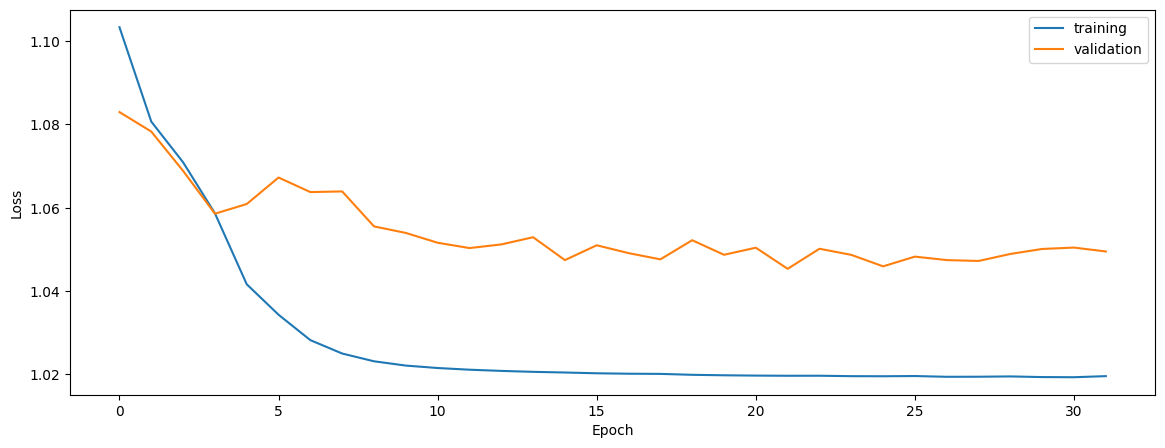

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.48556385347763603


0.451765824414528


0.4872997853734679


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.6115224556577824


0.579735067765443


0.6299029215763138


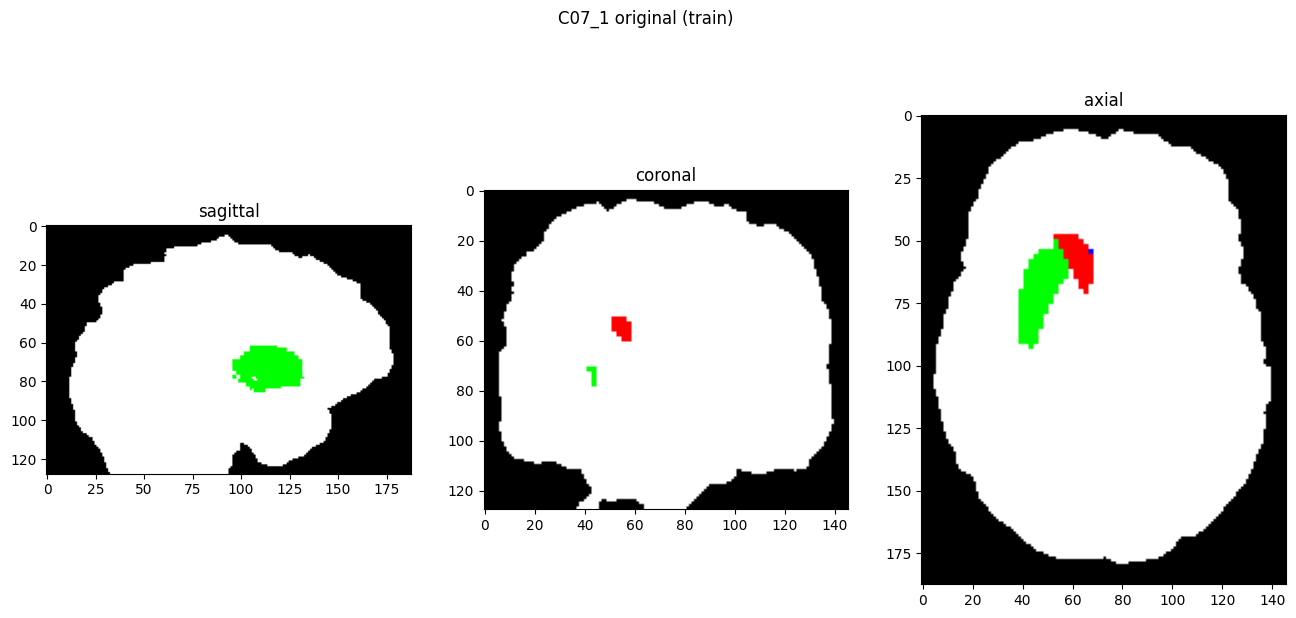

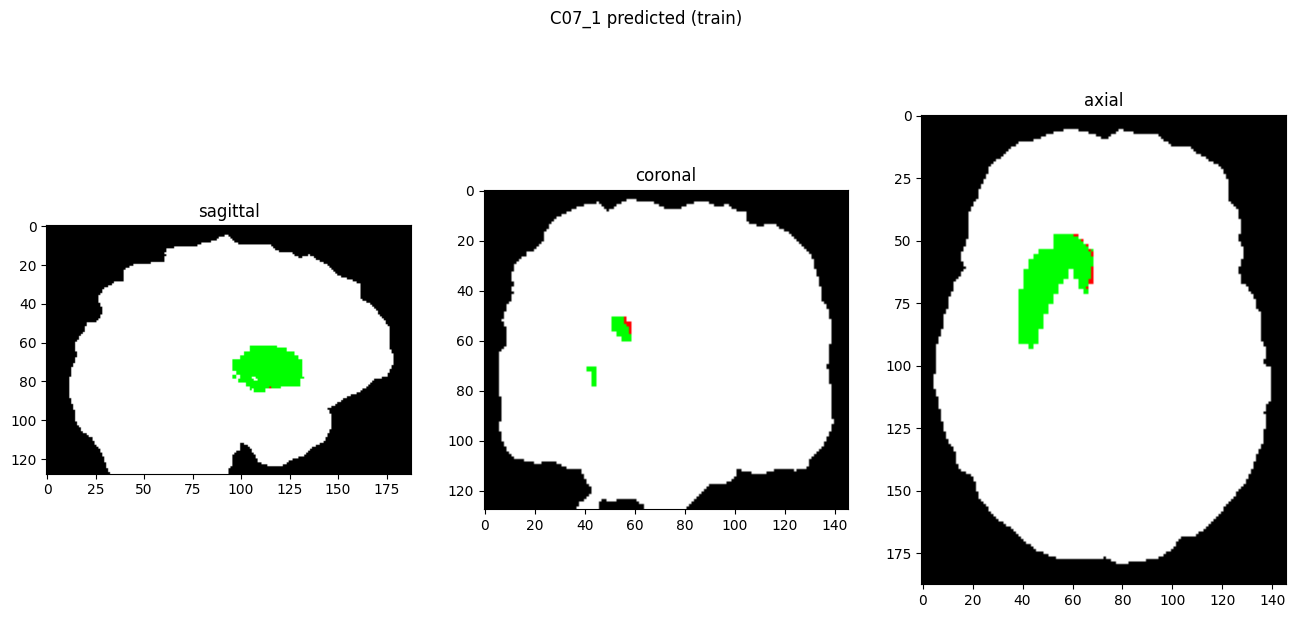

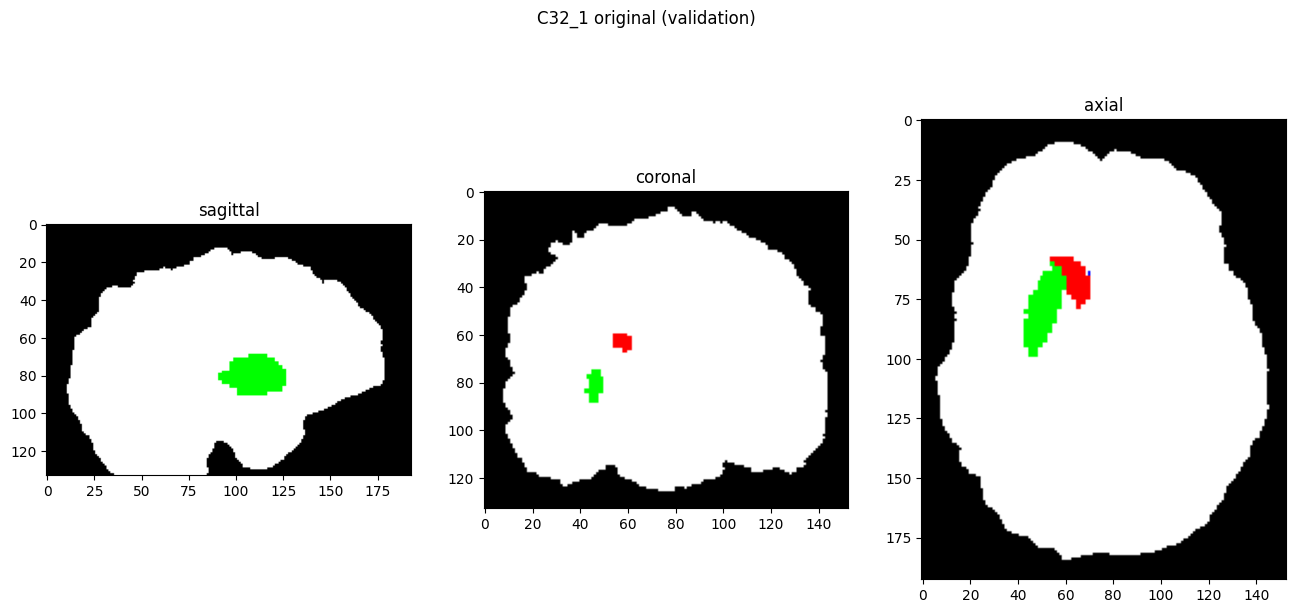

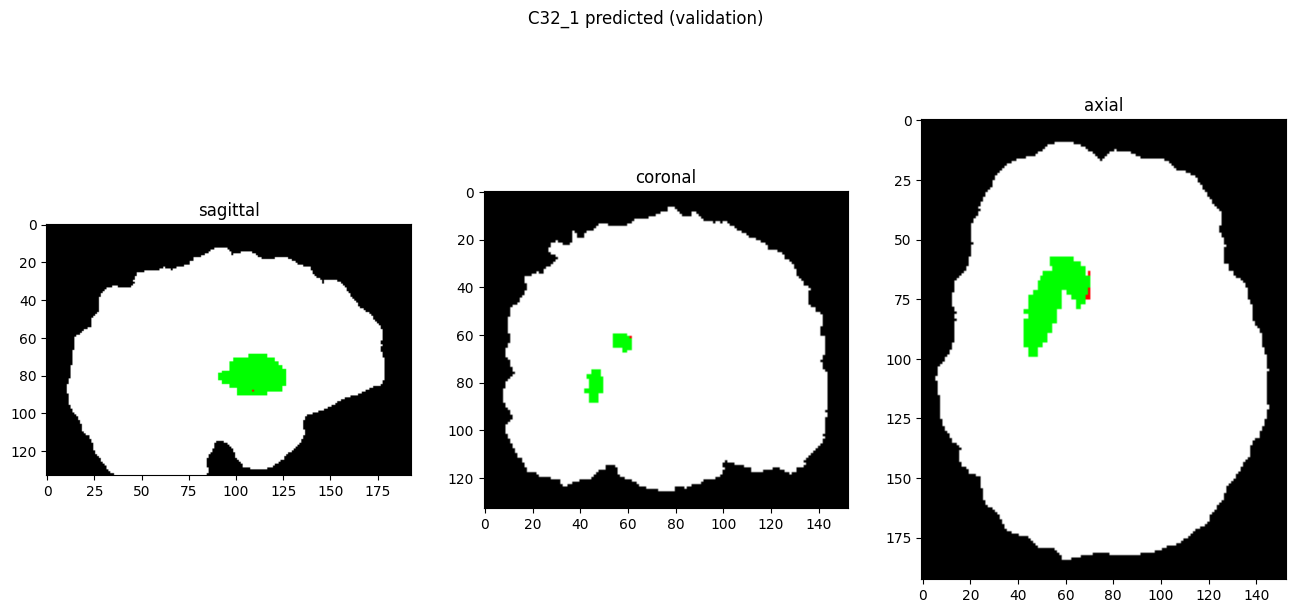

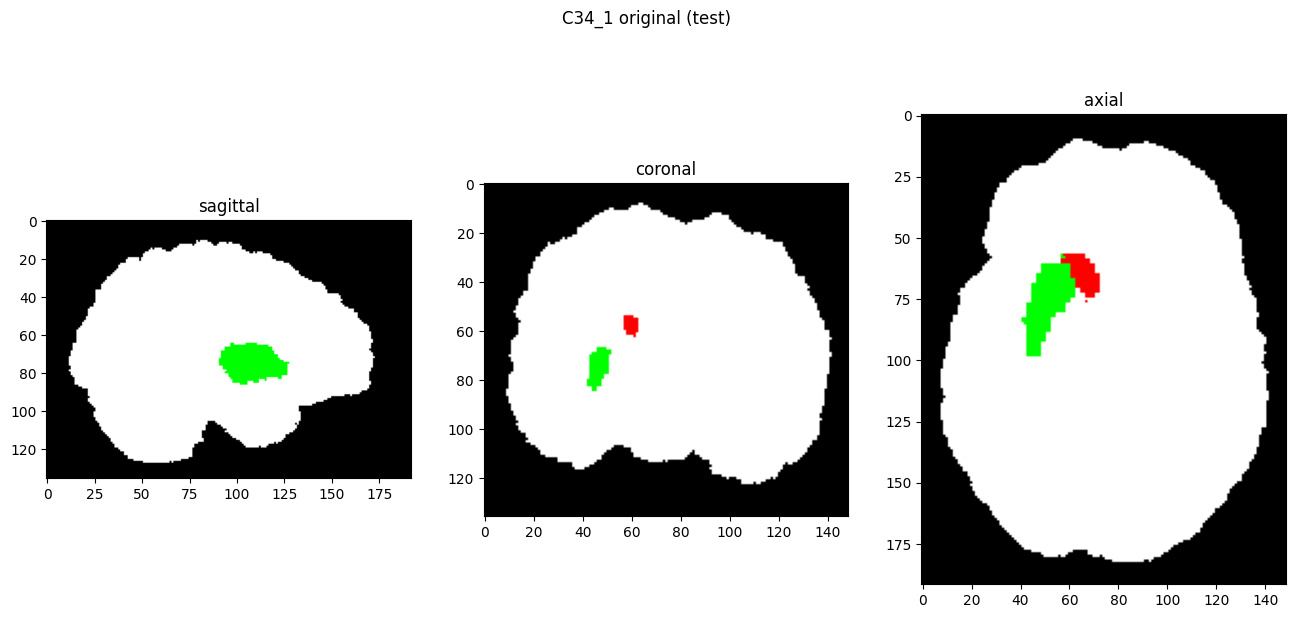

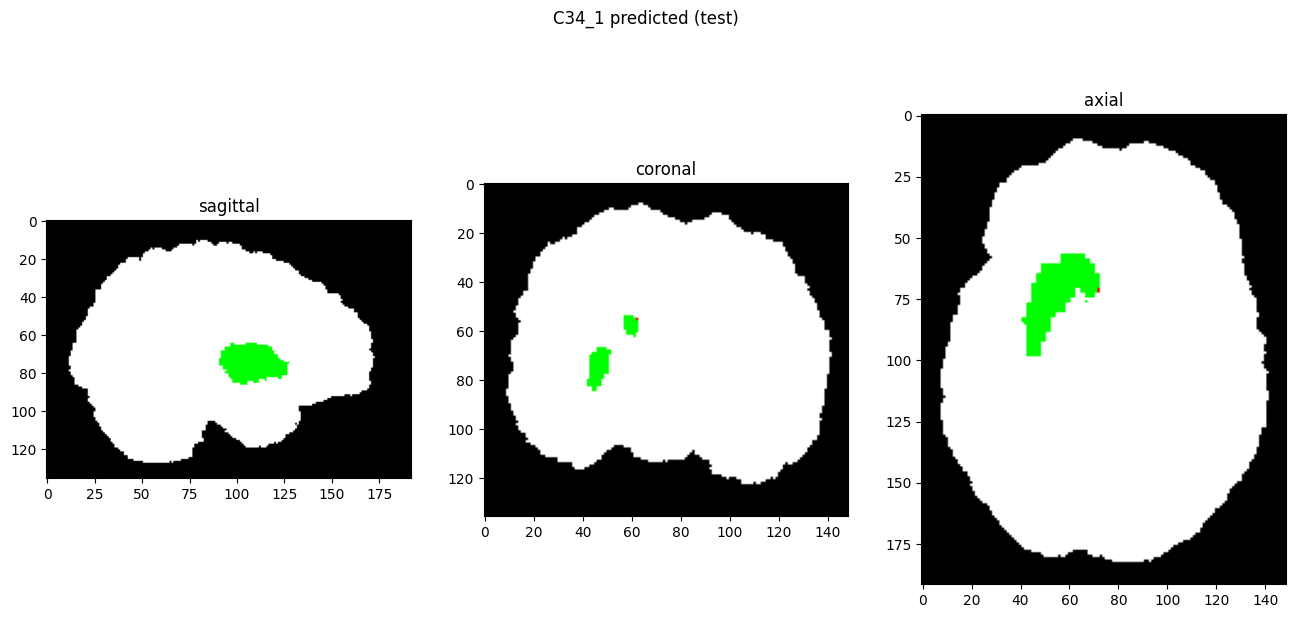

In [9]:
showResults(model, gen, threshold=0)